In [ ]:
# Install on Google Colab
!pip install scanpy anndata pandas scikit-learn matplotlib seaborn gseapy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=ee269d613dd73e6340f124449a957f3c508a87d377c8fd6d6f9304e6d5e9bf1a
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount to the '/content/drive' directory
data_path = '/content/drive/MyDrive/GSM3169075_filtered_gene_bc_matrices_h5.h5'  # Set the path to your data file

Mounted at /content/drive


In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
# Load the dataset
adata = sc.read_10x_h5(data_path)
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [ ]:
# Basic information
print(adata)


AnnData object with n_obs × n_vars = 3372 × 58302
    var: 'gene_ids'


In [ ]:
# Preprocessing: Filter out cells and genes with low counts
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# Calculate the percentage of mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [ ]:
# Filter based on QC
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# Highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [ ]:
# Scaling the data
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


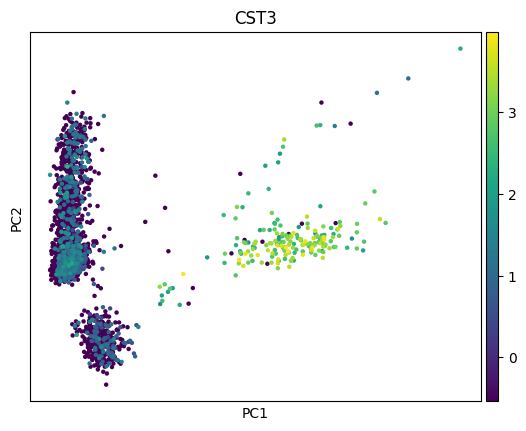

In [ ]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

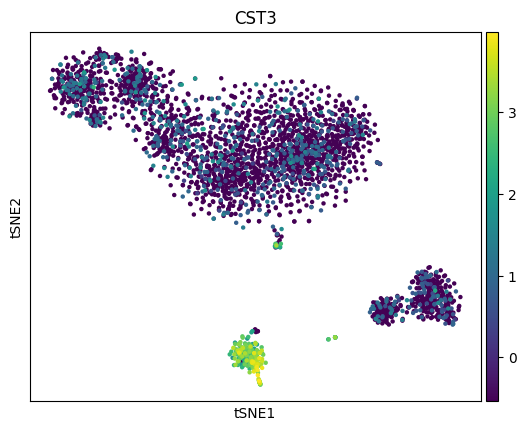

In [ ]:
# t-SNE
sc.tl.tsne(adata, n_pcs=50)
sc.pl.tsne(adata, color='CST3')

In [ ]:
# K-means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca'])

In [ ]:
# Silhouette Score (for clustering quality)
score = silhouette_score(adata.obsm['X_pca'], adata.obs['kmeans'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.2309814691543579


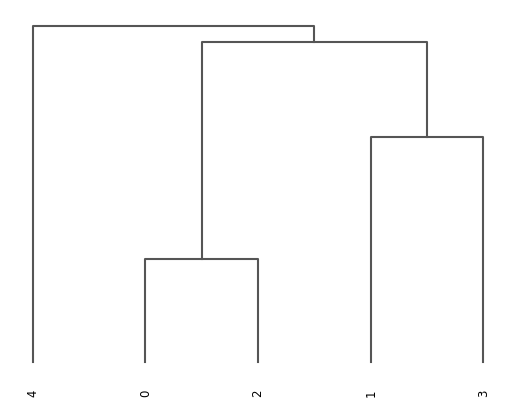

<Axes: >

In [ ]:
# Convert the 'kmeans' column to categorical
adata.obs['kmeans'] = adata.obs['kmeans'].astype('category')

# Hierarchical Clustering
sc.tl.dendrogram(adata, groupby='kmeans')
sc.pl.dendrogram(adata, groupby='kmeans') # Added groupby argument here

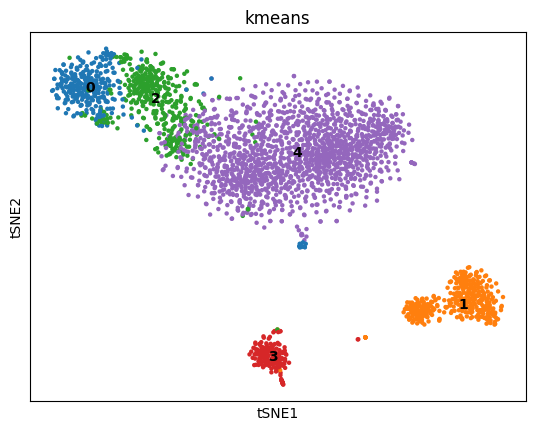

In [ ]:
# Plot clusters on t-SNE
sc.pl.tsne(adata, color='kmeans', legend_loc='on data')

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


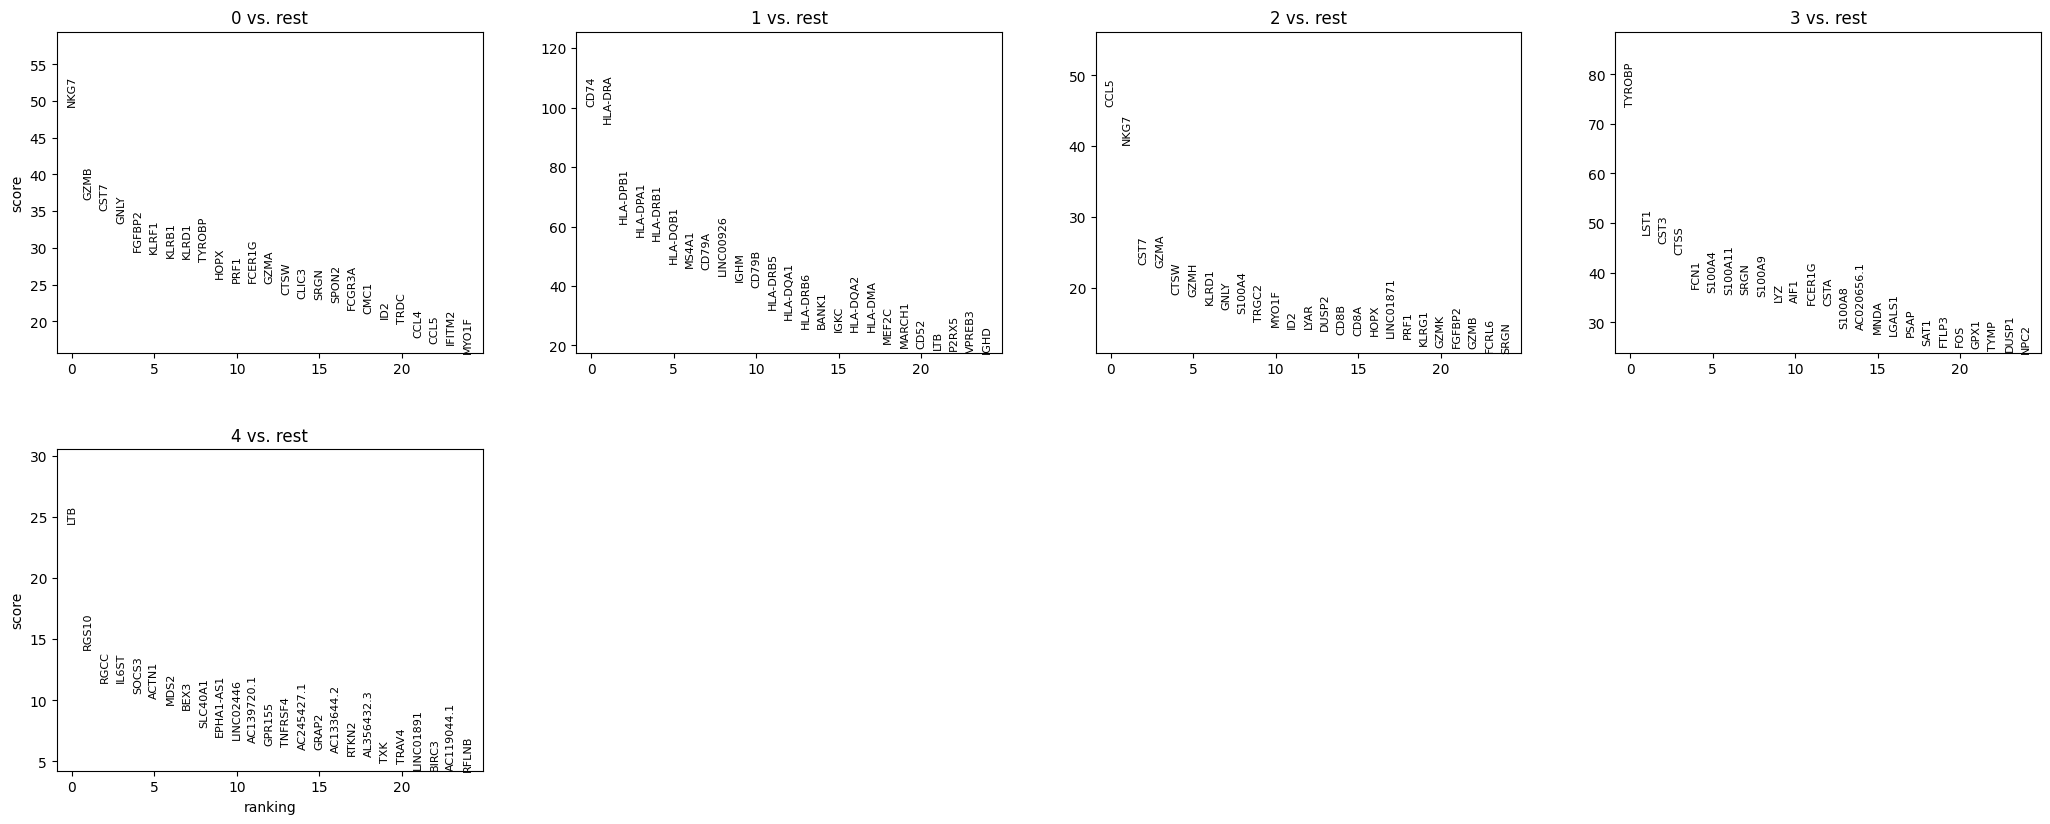

In [ ]:
# Differential Expression Analysis
adata.obs['kmeans'] = adata.obs['kmeans'].astype('category') # Ensure 'kmeans' is categorical before calling rank_genes_groups
sc.tl.rank_genes_groups(adata, 'kmeans', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


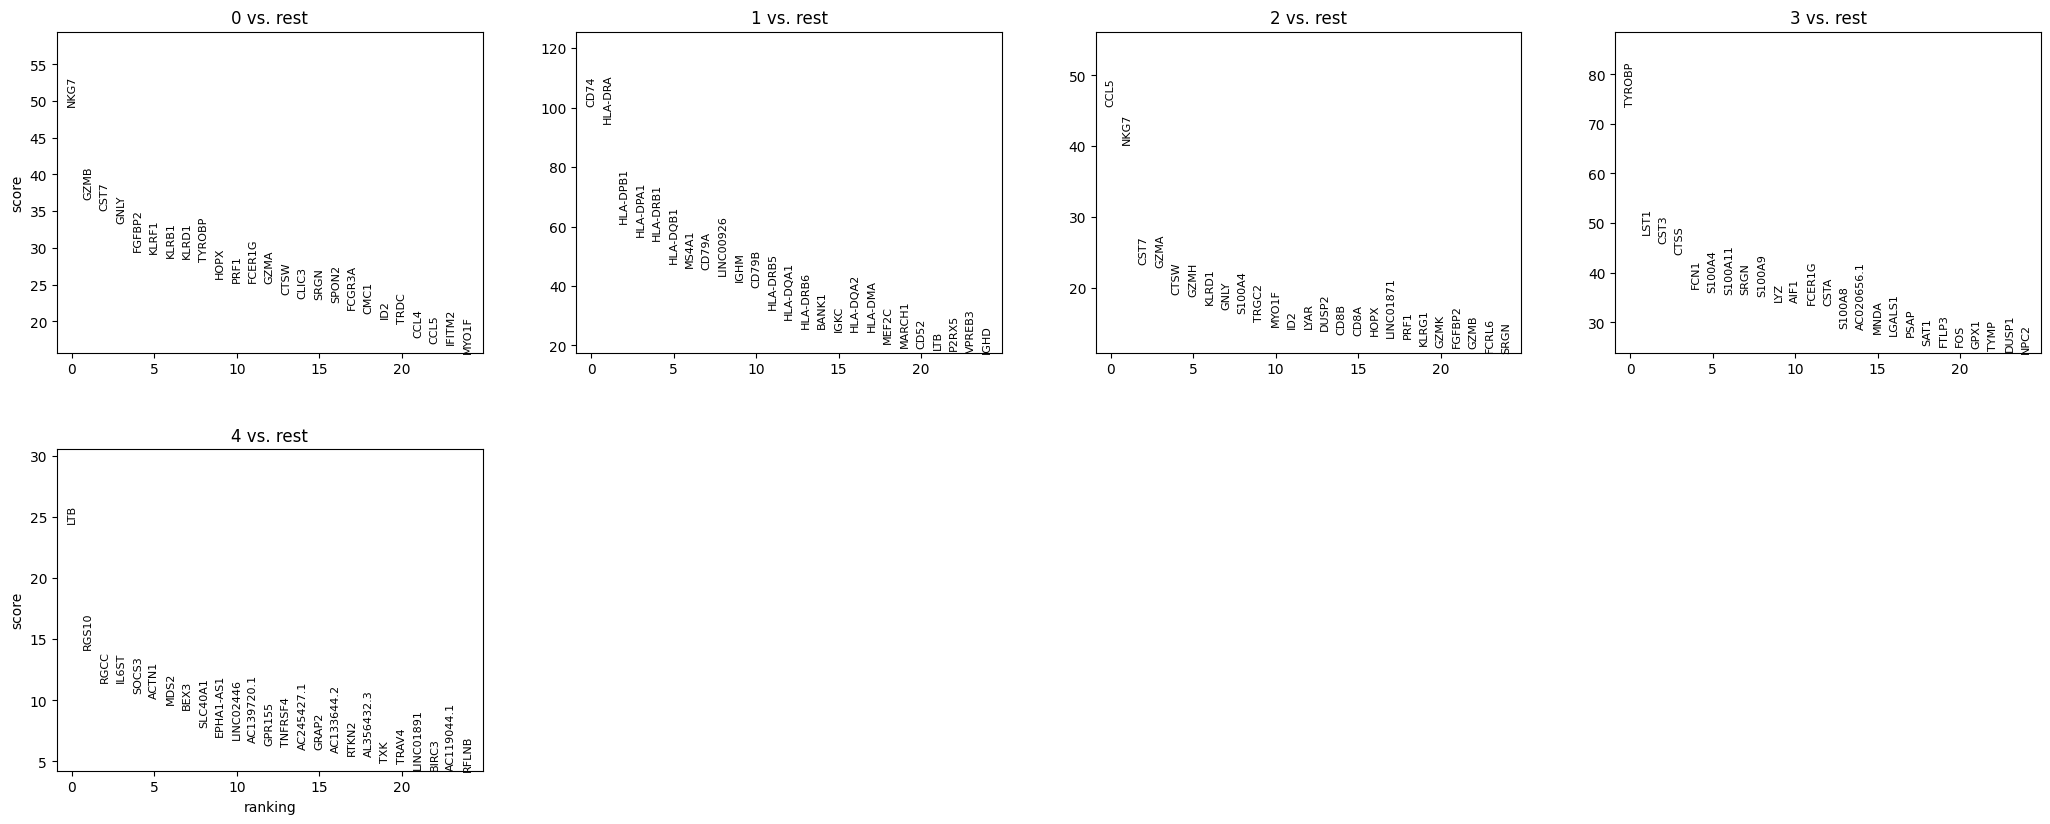

In [ ]:
import pandas as pd

# ... your existing code ...

# Differential Expression Analysis
adata.obs['kmeans'] = adata.obs['kmeans'].astype('category') # Ensure 'kmeans' is categorical before calling rank_genes_groups
sc.tl.rank_genes_groups(adata, 'kmeans', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# Pathway Enrichment (GSEA)
gene_list = adata.uns['rank_genes_groups']['names']['0'][:100]

# Convert gene_list to a plain Python list:
gene_list = gene_list.tolist()

# Perform enrichment analysis:
enrichment_res = gp.enrichr(gene_list=gene_list,
                           gene_sets='KEGG_2019_Human',
                           organism='Human')
print(enrichment_res.results.head())

          Gene_set                                       Term Overlap  \
0  KEGG_2019_Human  Natural killer cell mediated cytotoxicity  10/131   
1  KEGG_2019_Human                Chemokine signaling pathway   7/190   
2  KEGG_2019_Human                  Graft-versus-host disease    4/41   
3  KEGG_2019_Human           Th1 and Th2 cell differentiation    4/92   
4  KEGG_2019_Human       Toll-like receptor signaling pathway   4/104   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.078984e-09      1.057404e-07            0                     0   
1  4.751556e-05      1.688524e-03            0                     0   
2  5.168950e-05      1.688524e-03            0                     0   
3  1.173837e-03      2.875902e-02            0                     0   
4  1.845537e-03      3.617253e-02            0                     0   

   Odds Ratio  Combined Score  \
0   18.162534      375.006313   
1    8.109701       80.727639   
2   22.368243      220.780284

In [ ]:
# Perform GSEA
enrichment_res = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2019_Human', organism='Human')
print(enrichment_res.results.head())

          Gene_set                                       Term Overlap  \
0  KEGG_2019_Human  Natural killer cell mediated cytotoxicity  10/131   
1  KEGG_2019_Human                Chemokine signaling pathway   7/190   
2  KEGG_2019_Human                  Graft-versus-host disease    4/41   
3  KEGG_2019_Human           Th1 and Th2 cell differentiation    4/92   
4  KEGG_2019_Human       Toll-like receptor signaling pathway   4/104   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.078984e-09      1.057404e-07            0                     0   
1  4.751556e-05      1.688524e-03            0                     0   
2  5.168950e-05      1.688524e-03            0                     0   
3  1.173837e-03      2.875902e-02            0                     0   
4  1.845537e-03      3.617253e-02            0                     0   

   Odds Ratio  Combined Score  \
0   18.162534      375.006313   
1    8.109701       80.727639   
2   22.368243      220.780284

/usr/local/lib/python3.10/dist-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


<Axes: title={'center': 'KEGG Pathway Enrichment'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

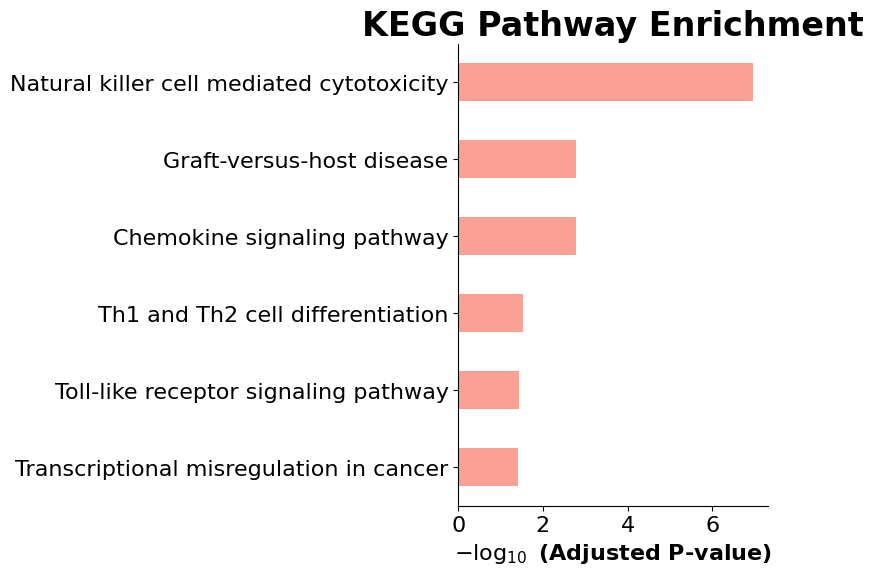

In [ ]:
# Plot Enrichment Results
gp.barplot(enrichment_res.res2d, title='KEGG Pathway Enrichment', cutoff=0.05)


In [ ]:
# Save the processed data
#adata.write('pbmc_3k_processed.h5ad')